In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random



Creating simple STDP network:
  DA neurons: 20
  D1 MSNs: 50
  D2 MSNs: 50
Creating STDP connections...
Created 576 STDP synapses
Starting simulation for 500.0ms...
REWARD applied at t=100.0ms
REWARD applied at t=100.1ms
DA reset to baseline at t=150.0ms
DA reset to baseline at t=150.1ms
REWARD applied at t=300.0ms
REWARD applied at t=300.1ms
DA reset to baseline at t=349.9ms
DA reset to baseline at t=350.0ms


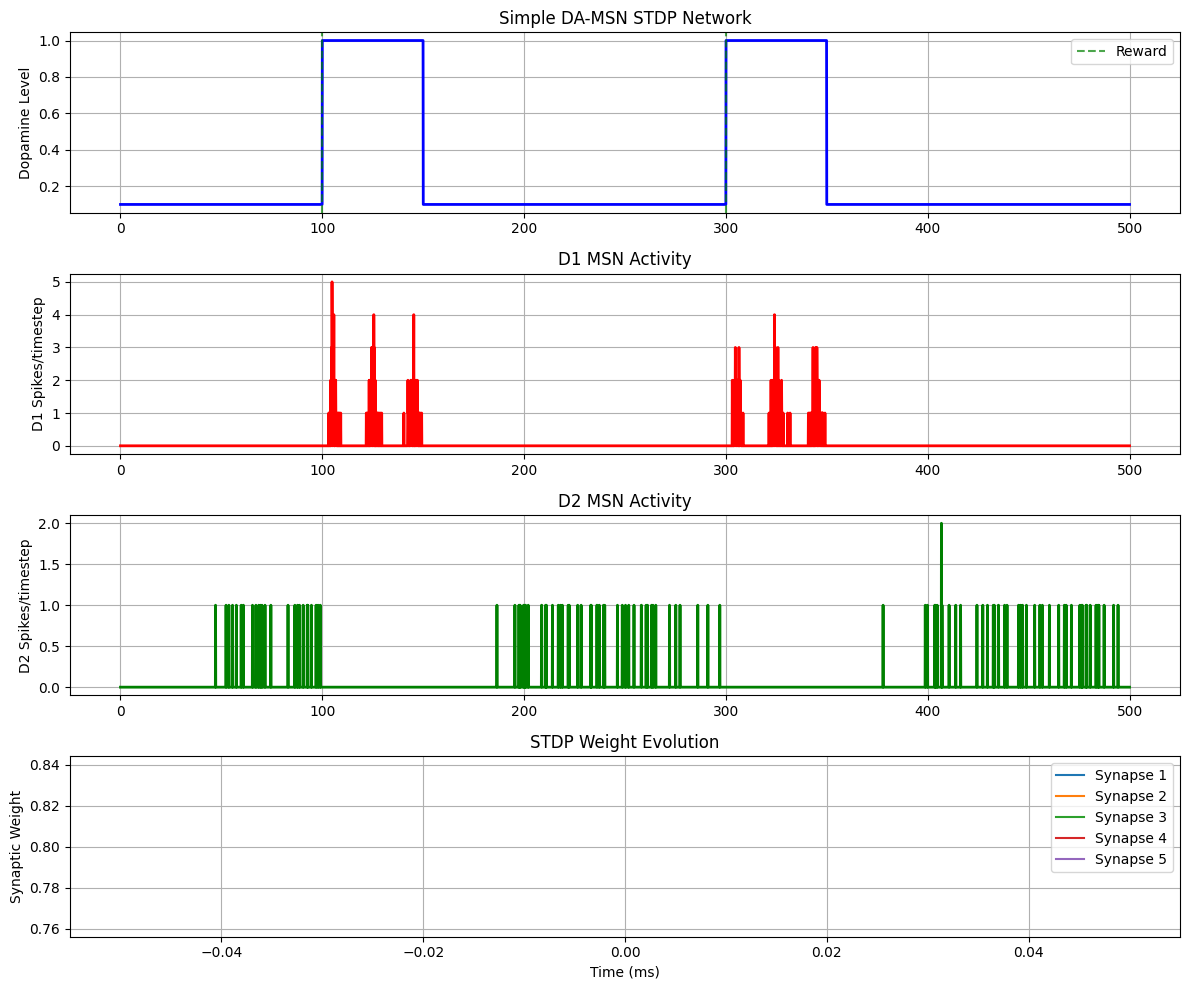


=== STDP Analysis ===
Initial weight: mean=0.700, std=0.100
Final weight: mean=0.700, std=0.100
Potentiated synapses: 0/576 (0.0%)
Depressed synapses: 0/576 (0.0%)

=== Key Concepts Demonstrated ===
1. DA neurons fire at baseline (~5Hz) and burst during reward (~30Hz)
2. D1 MSNs are excited by high dopamine, D2 MSNs are inhibited
3. STDP strengthens synapses when pre->post timing is good
4. Weight changes accumulate over multiple reward episodes
5. Network learns to associate DA bursts with MSN activity patterns


In [ ]:

# =============================================================================
# STEP 1: Basic Neuron Classes
# =============================================================================

class SimpleNeuron:
    """Basic integrate-and-fire neuron"""
    def __init__(self, name: str, threshold: float = -50.0, reset: float = -70.0, 
                 rest: float = -70.0, tau: float = 10.0):
        self.name = name
        self.threshold = threshold
        self.reset = reset  
        self.rest = rest
        self.tau = tau
        
        # State variables
        self.membrane_potential = rest
        self.spike_times = []
        self.time = 0.0
        
    def update(self, dt: float, input_current: float = 0.0):
        """Update neuron for one timestep"""
        # Leaky integrate-and-fire equation
        dv = (-(self.membrane_potential - self.rest) + input_current) / self.tau
        self.membrane_potential += dv * dt
        
        # Check for spike
        if self.membrane_potential >= self.threshold:
            self.spike_times.append(self.time)  # Record spike time
            self.membrane_potential = self.reset  # Reset potential
            return True
        return False
    
    def set_time(self, time: float):
        """Set current simulation time"""
        self.time = time

class DANeuron(SimpleNeuron):
    """Dopamine neuron with tonic and phasic modes"""
    def __init__(self, name: str):
        super().__init__(name, threshold=-45.0, rest=-65.0, tau=8.0)
        self.firing_rate = 0.05  # 5Hz baseline (realistic DA neuron)
        self.burst_mode = False
        self.dopamine_level = 0.1  # Baseline dopamine
        
    def set_burst_mode(self, burst: bool):
        """Switch between tonic and phasic firing"""
        self.burst_mode = burst
        if burst:
            self.firing_rate = 0.3  # 30Hz during reward
            self.dopamine_level = 1.0  # High dopamine release
        else:
            self.firing_rate = 0.05  # Back to baseline
            self.dopamine_level = 0.1
    
    def update(self, dt: float, input_current: float = 0.0):
        """Update with stochastic firing"""
        # Add random spiking based on firing rate
        if np.random.random() < self.firing_rate * dt:
            input_current += 20.0  # Strong depolarization
        
        return super().update(dt, input_current)

class MSNeuron(SimpleNeuron):
    """Medium Spiny Neuron with dopamine sensitivity"""
    def __init__(self, name: str, receptor_type: str):
        super().__init__(name, threshold=-45.0, rest=-75.0, tau=15.0)
        self.receptor_type = receptor_type  # 'D1' or 'D2'
        
    def dopamine_modulation(self, dopamine_level: float):
        """Return current based on dopamine level and receptor type"""
        if self.receptor_type == 'D1':
            # D1: excited by high dopamine
            if dopamine_level > 0.5:
                return 15.0  # Strong excitation during DA bursts
            else:
                return 2.0   # Weak excitation at baseline
        else:  # D2
            # D2: inhibited by dopamine
            if dopamine_level > 0.5:
                return -10.0  # Inhibited during DA bursts  
            else:
                return 5.0    # Disinhibited at low DA

# =============================================================================
# STEP 2: STDP Synapse
# =============================================================================

class STDPSynapse:
    """Synapse with Spike-Timing Dependent Plasticity"""
    def __init__(self, pre_neuron, post_neuron, initial_weight: float = 0.5):
        self.pre_neuron = pre_neuron
        self.post_neuron = post_neuron
        self.weight = initial_weight
        
        # STDP parameters
        self.A_plus = 0.02   # LTP amplitude (potentiation)
        self.A_minus = -0.015 # LTD amplitude (depression) 
        self.tau_plus = 20.0  # LTP time constant (ms)
        self.tau_minus = 25.0 # LTD time constant (ms)
        self.max_weight = 2.0
        self.min_weight = 0.0
        
        # For tracking plasticity
        self.weight_history = [initial_weight]
        
    def get_synaptic_current(self, pre_spiked: bool):
        """Return synaptic current if presynaptic neuron spiked"""
        if pre_spiked:
            return self.weight * 10.0  # Scale weight to current
        return 0.0
    
    def update_stdp(self):
        """Update synaptic weight based on recent spike timing"""
        # Need at least one spike from each neuron
        if len(self.pre_neuron.spike_times) == 0 or len(self.post_neuron.spike_times) == 0:
            return
        
        # Look at recent spikes (last 3 from each neuron)
        recent_pre = self.pre_neuron.spike_times[-3:]
        recent_post = self.post_neuron.spike_times[-3:]
        
        weight_change = 0.0
        
        # Compare all recent spike pairs
        for pre_time in recent_pre:
            for post_time in recent_post:
                dt = post_time - pre_time  # Time difference
                
                if 0 < dt < 50:  # Post after pre within 50ms -> LTP
                    weight_change += self.A_plus * np.exp(-dt / self.tau_plus)
                elif -50 < dt < 0:  # Pre after post within 50ms -> LTD  
                    weight_change += self.A_minus * np.exp(dt / self.tau_minus)
        
        # Update weight with bounds
        self.weight += weight_change
        self.weight = np.clip(self.weight, self.min_weight, self.max_weight)
        self.weight_history.append(self.weight)

# =============================================================================
# STEP 3: Simple Network
# =============================================================================

class SimpleSTDPNetwork:
    """Network with DA neurons, MSNs, and STDP synapses"""
    def __init__(self, n_da: int = 50, n_d1: int = 100, n_d2: int = 100):
        print(f"Creating simple STDP network:")
        print(f"  DA neurons: {n_da}")
        print(f"  D1 MSNs: {n_d1}")  
        print(f"  D2 MSNs: {n_d2}")
        
        # Create neurons
        self.da_neurons = [DANeuron(f'DA_{i}') for i in range(n_da)]
        self.d1_neurons = [MSNeuron(f'D1_{i}', 'D1') for i in range(n_d1)]
        self.d2_neurons = [MSNeuron(f'D2_{i}', 'D2') for i in range(n_d2)]
        
        # Create STDP synapses (sparse connectivity)
        self.synapses = []
        self.create_connections()
        
        # Simulation variables
        self.time = 0.0
        self.dt = 0.1  # 0.1ms timestep
        
        # Recording
        self.dopamine_history = []
        self.d1_spikes_history = []
        self.d2_spikes_history = []
        self.time_history = []
        
    def create_connections(self):
        """Create DA->MSN connections with STDP"""
        print("Creating STDP connections...")
        
        # Connect each DA neuron to random subset of MSNs
        connection_prob = 0.3  # 30% connectivity
        
        for da_neuron in self.da_neurons:
            # Connect to D1 MSNs
            for d1_neuron in self.d1_neurons:
                if np.random.random() < connection_prob:
                    synapse = STDPSynapse(da_neuron, d1_neuron, initial_weight=0.8)
                    self.synapses.append(synapse)
            
            # Connect to D2 MSNs  
            for d2_neuron in self.d2_neurons:
                if np.random.random() < connection_prob:
                    synapse = STDPSynapse(da_neuron, d2_neuron, initial_weight=0.6)
                    self.synapses.append(synapse)
        
        print(f"Created {len(self.synapses)} STDP synapses")
    
    def get_average_dopamine(self):
        """Calculate average dopamine level"""
        return np.mean([neuron.dopamine_level for neuron in self.da_neurons])
    
    def apply_reward(self):
        """Trigger dopamine burst (reward signal)"""
        for da_neuron in self.da_neurons:
            da_neuron.set_burst_mode(True)
        print(f"REWARD applied at t={self.time:.1f}ms")
    
    def reset_dopamine(self):
        """Return to baseline dopamine"""
        for da_neuron in self.da_neurons:
            da_neuron.set_burst_mode(False)
        print(f"DA reset to baseline at t={self.time:.1f}ms")
    
    def update_network(self):
        """Update all neurons and synapses for one timestep"""
        # Set time for all neurons
        all_neurons = self.da_neurons + self.d1_neurons + self.d2_neurons
        for neuron in all_neurons:
            neuron.set_time(self.time)
        
        # Track which neurons spike this timestep
        spikes = {}
        avg_dopamine = self.get_average_dopamine()
        
        # Update all neurons
        for neuron in all_neurons:
            # Calculate input current
            synaptic_input = 0.0
            
            # Add dopamine modulation for MSNs
            if isinstance(neuron, MSNeuron):
                dopamine_input = neuron.dopamine_modulation(avg_dopamine)
                synaptic_input += dopamine_input
                
                # Add cortical-like excitatory drive (MSNs need excitation to spike)
                cortical_drive = np.random.poisson(3) * 8.0  # Random excitatory input
                synaptic_input += cortical_drive
            
            # Add synaptic inputs from STDP connections
            for synapse in self.synapses:
                if synapse.post_neuron == neuron:
                    pre_spiked = spikes.get(synapse.pre_neuron, False)
                    synaptic_input += synapse.get_synaptic_current(pre_spiked)
            
            # Add noise
            noise = np.random.normal(0, 2.0)
            
            # Update neuron
            spiked = neuron.update(self.dt, synaptic_input + noise)
            spikes[neuron] = spiked
        
        # Update STDP every 5ms (for efficiency)
        if abs(self.time % 5.0) < self.dt:
            for synapse in self.synapses:
                synapse.update_stdp()
        
        # Record network state
        self.dopamine_history.append(avg_dopamine)
        self.d1_spikes_history.append(sum(spikes.get(n, False) for n in self.d1_neurons))
        self.d2_spikes_history.append(sum(spikes.get(n, False) for n in self.d2_neurons))
        self.time_history.append(self.time)
        
        self.time += self.dt
    
    def simulate(self, duration: float):
        """Run simulation with reward scenario"""
        print(f"Starting simulation for {duration}ms...")
        steps = int(duration / self.dt)
        
        for step in range(steps):
            self.update_network()
            
            # Simple reward protocol
            if abs(self.time - 100.0) < self.dt:  # Reward at 100ms
                self.apply_reward()
            elif abs(self.time - 150.0) < self.dt:  # Reset at 150ms
                self.reset_dopamine()
            elif abs(self.time - 300.0) < self.dt:  # Second reward at 300ms
                self.apply_reward()  
            elif abs(self.time - 350.0) < self.dt:  # Reset at 350ms
                self.reset_dopamine()
    
    def plot_results(self):
        """Plot network activity and STDP changes"""
        fig, axes = plt.subplots(4, 1, figsize=(12, 10))
        
        # Dopamine levels
        axes[0].plot(self.time_history, self.dopamine_history, 'b-', linewidth=2)
        axes[0].set_ylabel('Dopamine Level')
        axes[0].set_title('Simple DA-MSN STDP Network')
        axes[0].axvline(100, color='g', linestyle='--', alpha=0.7, label='Reward')
        axes[0].axvline(300, color='g', linestyle='--', alpha=0.7)
        axes[0].legend()
        axes[0].grid(True)
        
        # D1 MSN activity
        axes[1].plot(self.time_history, self.d1_spikes_history, 'r-', linewidth=2)
        axes[1].set_ylabel('D1 Spikes/timestep')
        axes[1].set_title('D1 MSN Activity')
        axes[1].grid(True)
        
        # D2 MSN activity  
        axes[2].plot(self.time_history, self.d2_spikes_history, 'g-', linewidth=2)
        axes[2].set_ylabel('D2 Spikes/timestep')
        axes[2].set_title('D2 MSN Activity')
        axes[2].grid(True)
        
        # STDP weight changes
        if len(self.synapses) > 0:
            sample_weights = [s.weight_history for s in self.synapses[:5]]  # First 5 synapses
            for i, weights in enumerate(sample_weights):
                time_points = np.linspace(0, len(weights)-1, len(weights)) * 5.0  # Every 5ms
                axes[3].plot(time_points, weights, label=f'Synapse {i+1}')
            axes[3].set_ylabel('Synaptic Weight')
            axes[3].set_xlabel('Time (ms)')
            axes[3].set_title('STDP Weight Evolution')  
            axes[3].legend()
            axes[3].grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def analyze_stdp(self):
        """Analyze STDP learning"""
        print("\n=== STDP Analysis ===")
        
        # Weight statistics
        initial_weights = [s.weight_history[0] for s in self.synapses]
        final_weights = [s.weight_history[-1] for s in self.synapses]
        
        print(f"Initial weight: mean={np.mean(initial_weights):.3f}, std={np.std(initial_weights):.3f}")
        print(f"Final weight: mean={np.mean(final_weights):.3f}, std={np.std(final_weights):.3f}")
        
        # Potentiated vs depressed synapses
        weight_changes = [final - initial for initial, final in zip(initial_weights, final_weights)]
        potentiated = sum(1 for w in weight_changes if w > 0.01)
        depressed = sum(1 for w in weight_changes if w < -0.01)
        
        print(f"Potentiated synapses: {potentiated}/{len(self.synapses)} ({100*potentiated/len(self.synapses):.1f}%)")
        print(f"Depressed synapses: {depressed}/{len(self.synapses)} ({100*depressed/len(self.synapses):.1f}%)")

# =============================================================================
# STEP 4: Example Usage
# =============================================================================

if __name__ == "__main__":
    # Create and run simple network
    network = SimpleSTDPNetwork(n_da=20, n_d1=50, n_d2=50)
    
    # Run simulation
    network.simulate(duration=500.0)  # 500ms
    
    # Analyze and plot results
    network.plot_results()
    network.analyze_stdp()
    
    print("\n=== Key Concepts Demonstrated ===")
    print("1. DA neurons fire at baseline (~5Hz) and burst during reward (~30Hz)")
    print("2. D1 MSNs are excited by high dopamine, D2 MSNs are inhibited") 
    print("3. STDP strengthens synapses when pre->post timing is good")
    print("4. Weight changes accumulate over multiple reward episodes")
    print("5. Network learns to associate DA bursts with MSN activity patterns")